In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.utils import to_categorical

import numpy as np


from sklearn.metrics import adjusted_rand_score , adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
import keras
import tensorflow as tf
from PIL import Image
import math

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np
import pickle

from tensorflow.keras.utils import to_categorical
import math
import os
from IPython.display import clear_output
from collections import Counter


In [3]:
f = open(r'gtex_gene_expected_count')
samples = f.readline()
samples = samples.split('\t')

In [4]:
sample_count = len(samples[1:])

In [6]:
g = open(r'GTEX_phenotype')
g.readline()
_dict ={}
for line in g:
    fileds = line.split('\t')
    _dict[fileds[0].strip()] = fileds[1].strip()

In [7]:
phenotypes = []
for s in samples[1:]:
    if s.strip() not in _dict.keys():
        phenotypes.append('NA')
    else:
        phenotypes.append(_dict[s.strip()])

In [8]:
Counter(phenotypes)

Counter({'Cells - EBV-transformed lymphocytes': 107,
         'Artery - Tibial': 280,
         'Brain - Hippocampus': 84,
         'Thyroid': 279,
         'Pancreas': 167,
         'Muscle - Skeletal': 395,
         'Lung': 288,
         'Skin - Not Sun Exposed (Suprapubic)': 232,
         'Colon - Transverse': 166,
         'Nerve - Tibial': 278,
         'Skin - Sun Exposed (Lower leg)': 324,
         'Adipose - Subcutaneous': 316,
         'Whole Blood': 337,
         'Ovary': 88,
         'Heart - Left Ventricle': 201,
         'Breast - Mammary Tissue': 178,
         'Artery - Coronary': 118,
         'Pituitary': 107,
         'Testis': 165,
         'Artery - Aorta': 206,
         'Vagina': 85,
         'Esophagus - Muscularis': 245,
         'Colon - Sigmoid': 141,
         'Esophagus - Gastroesophageal Junction': 136,
         'Small Intestine - Terminal Ileum': 92,
         'Brain - Cerebellum': 117,
         'Heart - Atrial Appendage': 175,
         'Spleen': 100,
         

In [8]:
gen_count = 0
for line in f:
    fileds = line.split('\t')
    values = [float(x.strip()) for x in fileds[1:]]
#     
    values = np.asarray(values)
    if values.mean() >= 0.1:
        gen_count +=1
        clear_output(wait=True)
        print(gen_count)
f.close()

39967


In [9]:
data = np.zeros((gen_count , sample_count), dtype='float32')

In [10]:
f = open(r'TcgaTargetGtex_RSEM_Hugo_norm_count')
f.readline()
i = 0
for line in f:
    fileds = line.split('\t')
    values = [float(x.strip()) for x in fileds[1:]]
    values = np.asarray(values)
    if values.mean() >= 0.1:
        data[i] = values
        i += 1
        print(i)
        clear_output(wait=True)
f.close()

39967


In [11]:
data = data.T
x_train = data 

In [12]:
print(data.shape , np.min(data) , np.max(data) ,np.mean(data))

(19120, 39967) 0.0 28.1127 4.4406753


In [13]:
tsne = TSNE(n_components=2, verbose=1)

In [14]:
tsne_results = tsne.fit_transform(data.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 39967 samples in 0.511s...
[t-SNE] Computed neighbors for 39967 samples in 338.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39967
[t-SNE] Computed conditional probabilities for sample 2000 / 39967
[t-SNE] Computed conditional probabilities for sample 3000 / 39967
[t-SNE] Computed conditional probabilities for sample 4000 / 39967
[t-SNE] Computed conditional probabilities for sample 5000 / 39967
[t-SNE] Computed conditional probabilities for sample 6000 / 39967
[t-SNE] Computed conditional probabilities for sample 7000 / 39967
[t-SNE] Computed conditional probabilities for sample 8000 / 39967
[t-SNE] Computed conditional probabilities for sample 9000 / 39967
[t-SNE] Computed conditional probabilities for sample 10000 / 39967
[t-SNE] Computed conditional probabilities for sample 11000 / 39967
[t-SNE] Computed conditional probabilities for sample 12000 / 39967
[t-SNE] Computed conditional probabilities for s

In [15]:
framedata = {"tsne-2d-one": tsne_results[:,0] , "tsne-2d-two": tsne_results[:,1] } 

In [16]:
df = pd.DataFrame(framedata)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

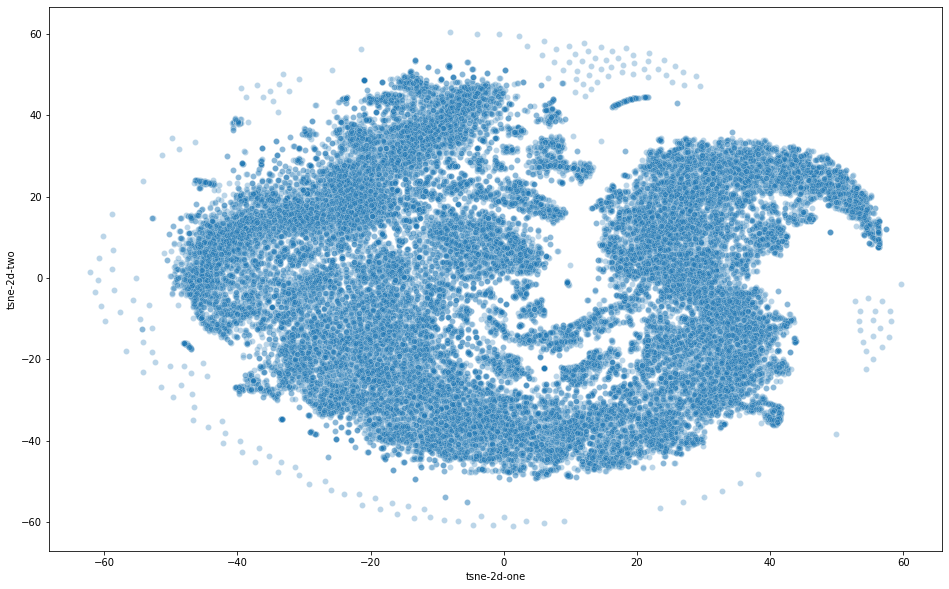

In [17]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df,
    legend="full",
    alpha=0.3
)

In [18]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [19]:
hull = ConvexHull(tsne_results)

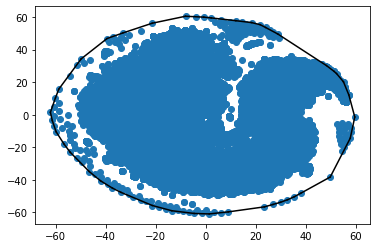

In [20]:
plt.plot(tsne_results[:,0], tsne_results[:,1], 'o')
for simplex in hull.simplices:

    plt.plot(tsne_results[simplex, 0], tsne_results[simplex, 1], 'k-')

In [21]:
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

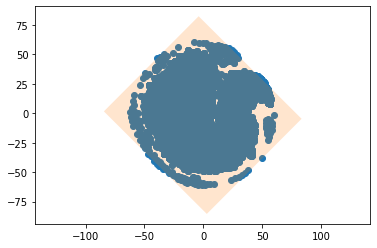

In [22]:
plt.scatter(tsne_results[:,0], tsne_results[:,1])
bbox = minimum_bounding_rectangle(tsne_results)
plt.fill(bbox[:,0], bbox[:,1], alpha=0.2)
plt.axis('equal')
plt.show()

In [23]:
bbox

array([[ 83.34616852,  -4.66095924],
       [  2.89765024, -85.41290283],
       [-84.48482513,   1.64122641],
       [ -4.0363102 ,  82.39317322]])

In [24]:
unq, count = np.unique(tsne_results, axis=0, return_counts=True)
print(unq, count)

[[-62.14836     1.5139775]
 [-61.412067   -3.5228636]
 [-60.8428     -0.5333982]
 ...
 [ 58.021984   -7.9691243]
 [ 58.10518   -10.610852 ]
 [ 59.69527    -1.3976911]] [1 1 1 ... 1 1 1]


In [25]:
theta = np.arctan((bbox[0][1]-bbox[1][1])/(bbox[0][0] - bbox[1][0]))

In [26]:
theta*180/np.pi

45.10784689475923

In [27]:
theta = - theta

In [28]:
def rotate(p, origin=(0, 0), theta=0):

    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

In [29]:
bbox_ = rotate(bbox, origin=bbox[0], theta=theta)

In [30]:
x_ = rotate(tsne_results, origin=bbox[0], theta=theta)

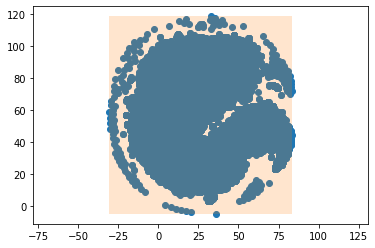

In [31]:
plt.scatter(x_[:,0], x_[:,1])
# bbox = minimum_bounding_rectangle(x_)
plt.fill(bbox_[:,0], bbox_[:,1], alpha=0.2)
plt.axis('equal')
plt.show()

In [32]:
bbox_

array([[ 83.34616852,  -4.66095924],
       [-30.63997312,  -4.66095924],
       [-30.6399778 , 118.68456528],
       [ 83.34616376, 118.68456992]])

In [33]:
np.max(x_,axis=0) - np.min(x_,axis=0)

array([113.9861441 , 123.34552169])

In [34]:
np.min(x_,axis=0)

array([-30.63997715,  -4.66095377])

In [35]:
y = x_ -  np.min(x_,axis=0)

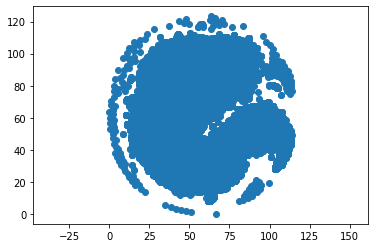

In [36]:
plt.scatter(y[:,0], y[:,1])
plt.axis('equal')
plt.show()

In [37]:
w , h = np.max(y , axis=0)

In [38]:
w , h = int(w) , int(h)

In [39]:
print(w,h)

113 123


In [40]:
y.shape

(39967, 2)

In [41]:
x_train.shape

(19120, 39967)

In [42]:
data = np.zeros((x_train.shape[0],w+1,h+1))

In [43]:
for i, profie in enumerate(x_train):
    counts = np.zeros((w+1,h+1))
    for j in range(x_train.shape[1]):
        x1 , x2 = int(y[j][0]) , int(y[j][1])
        data[i,x1,x2] = data[i,x1,x2] + profie[j]
        counts[x1,x2] +=1
    for k in range(w+1):
        for l in range(h+1):
            if counts[k,l]>1 :
                data[i , k , l] /= counts[k,l]

In [44]:
np.max(data)

27.33526674906413

In [45]:
data = data /np.max(data)

In [46]:
data.shape

(19120, 114, 124)

In [ ]:
left_padd = math.floor((128 - data.shape[1])/2)
right_padd = math.ceil((128 - data.shape[1])/2)
top_padd = math.floor((128 - data.shape[2])/2)
bottom_padd = math.ceil((128 - data.shape[2])/2)

In [47]:
data = np.pad(data , [(0,0),(left_padd,right_padd),(top_padd,bottom_padd)], 'constant')

In [48]:
data.shape

(19120, 128, 128)

In [ ]:
np.save('data.npy', data)

In [ ]:
data.shape

In [ ]:
x_train = data

In [ ]:
set_labels = set(phenotypes)

In [ ]:
num_classes = len(set_labels)

In [ ]:
num_classes

In [ ]:
dict_labels = {}
for i,l in enumerate(set_labels):
    dict_labels[l] = i

In [ ]:
labels = []
for l in phenotypes:
    labels.append(dict_labels[l])

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(labels , num_classes=num_classes)

In [ ]:
np.save('y_primary_disease_or_tissue.npy',y_train)

In [12]:
g = open(r'TcgaTargetGTEX_phenotype.txt')
g.readline()
_dict ={}
for line in g:
    fileds = line.split('\t')
    _dict[fileds[0].strip()] = fileds[3].strip()

In [13]:
phenotypes = []
for s in samples[1:]:
    if s.strip() not in _dict.keys():
        phenotypes.append('NA')
    else:
        phenotypes.append(_dict[s.strip()])

In [14]:
Counter(phenotypes)

Counter({'Cells - Ebv-Transformed Lymphocytes': 107,
         'Brain Lower Grade Glioma': 523,
         'Artery - Tibial': 281,
         'Liver Hepatocellular Carcinoma': 421,
         'Uterus': 78,
         'Thyroid': 279,
         'Cervical & Endocervical Cancer': 309,
         'Lung Adenocarcinoma': 574,
         'Colon Adenocarcinoma': 331,
         'Acute Myeloid Leukemia': 369,
         'Breast Invasive Carcinoma': 1212,
         'Muscle - Skeletal': 396,
         'Lung': 288,
         'Skin - Not Sun Exposed (Suprapubic)': 233,
         'Testicular Germ Cell Tumor': 154,
         'Nerve - Tibial': 278,
         'Esophagus - Mucosa': 273,
         'Sarcoma': 264,
         'Kidney Papillary Cell Carcinoma': 321,
         'Brain - Hippocampus': 84,
         'Skin - Sun Exposed (Lower Leg)': 324,
         'Stomach Adenocarcinoma': 450,
         'Prostate Adenocarcinoma': 548,
         'Esophageal Carcinoma': 195,
         'Skin Cutaneous Melanoma': 470,
         'Whole Blood': 337,


In [ ]:
set_labels = set(phenotypes)

In [ ]:
num_classes = len(set_labels)

In [ ]:
num_classes

In [ ]:
dict_labels = {}
for i,l in enumerate(set_labels):
    dict_labels[l] = i

In [ ]:
labels = []
for l in phenotypes:
    labels.append(dict_labels[l])

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(labels , num_classes=num_classes)

In [ ]:
np.save('y__primary_site.npy',y_train)

In [12]:
g = open(r'TcgaTargetGTEX_phenotype.txt')
g.readline()
_dict ={}
for line in g:
    fileds = line.split('\t')
    _dict[fileds[0].strip()] = fileds[4].strip()

In [13]:
phenotypes = []
for s in samples[1:]:
    if s.strip() not in _dict.keys():
        phenotypes.append('NA')
    else:
        phenotypes.append(_dict[s.strip()])

In [14]:
Counter(phenotypes)

Counter({'Cells - Ebv-Transformed Lymphocytes': 107,
         'Brain Lower Grade Glioma': 523,
         'Artery - Tibial': 281,
         'Liver Hepatocellular Carcinoma': 421,
         'Uterus': 78,
         'Thyroid': 279,
         'Cervical & Endocervical Cancer': 309,
         'Lung Adenocarcinoma': 574,
         'Colon Adenocarcinoma': 331,
         'Acute Myeloid Leukemia': 369,
         'Breast Invasive Carcinoma': 1212,
         'Muscle - Skeletal': 396,
         'Lung': 288,
         'Skin - Not Sun Exposed (Suprapubic)': 233,
         'Testicular Germ Cell Tumor': 154,
         'Nerve - Tibial': 278,
         'Esophagus - Mucosa': 273,
         'Sarcoma': 264,
         'Kidney Papillary Cell Carcinoma': 321,
         'Brain - Hippocampus': 84,
         'Skin - Sun Exposed (Lower Leg)': 324,
         'Stomach Adenocarcinoma': 450,
         'Prostate Adenocarcinoma': 548,
         'Esophageal Carcinoma': 195,
         'Skin Cutaneous Melanoma': 470,
         'Whole Blood': 337,


In [ ]:
set_labels = set(phenotypes)

In [ ]:
num_classes = len(set_labels)

In [ ]:
num_classes

In [ ]:
dict_labels = {}
for i,l in enumerate(set_labels):
    dict_labels[l] = i

In [ ]:
labels = []
for l in phenotypes:
    labels.append(dict_labels[l])

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(labels , num_classes=num_classes)

In [ ]:
np.save('y__sample_type.npy',y_train)